In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
sns.set()

# Preprocessing Libraries
from sklearn.preprocessing import RobustScaler

# Model training libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

# For checking acuracy
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
# Import csv to dataframe
# Download dataset from https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset/
raw = "archive/PS_20174392719_1491204439457_log.csv"
df = pd.read_csv(raw)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            6362620 non-null  int64  
 1   type            6362620 non-null  object 
 2   amount          6362620 non-null  float64
 3   nameOrig        6362620 non-null  object 
 4   oldbalanceOrg   6362620 non-null  float64
 5   newbalanceOrig  6362620 non-null  float64
 6   nameDest        6362620 non-null  object 
 7   oldbalanceDest  6362620 non-null  float64
 8   newbalanceDest  6362620 non-null  float64
 9   isFraud         6362620 non-null  int64  
 10  isFlaggedFraud  6362620 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


Text(0, 0.5, 'Count')

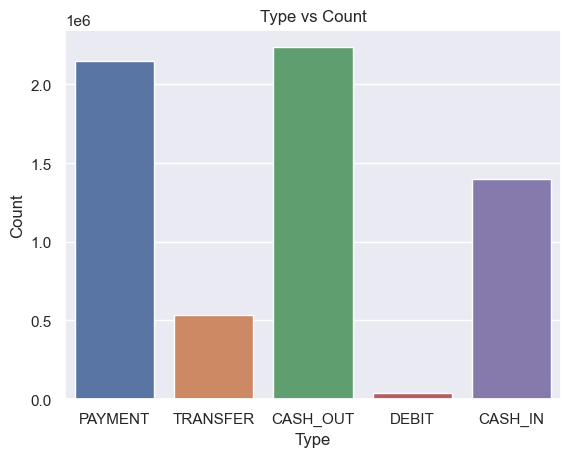

In [4]:
# Countplot of the 'type' column
plt.title("Type vs Count")
sns.countplot(df, x="type")
plt.xlabel("Type")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

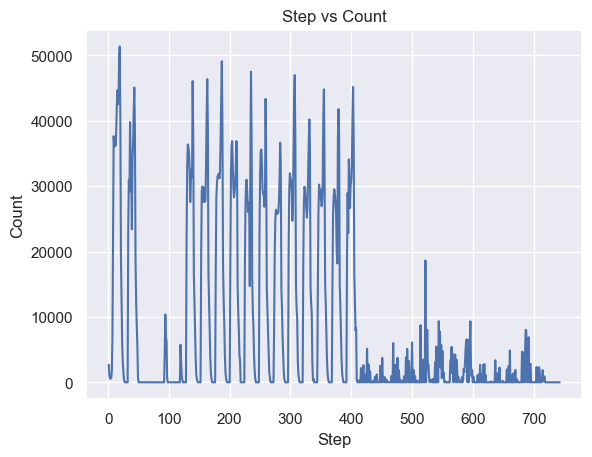

In [5]:
# Countplot of the 'step' column
plt.title("Step vs Count")
df['step'].value_counts().sort_index().plot(kind='line')
plt.xlabel("Step")
plt.ylabel("Count")

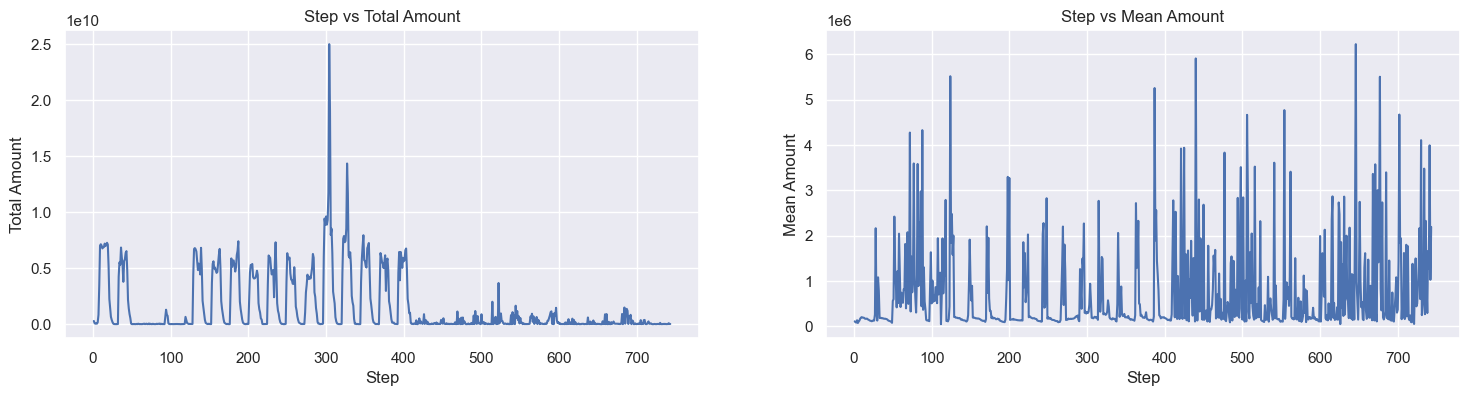

In [6]:
# Plot step vs amount max and mean

df_step_amount_sum = df[['step', "amount"]].groupby('step').sum()

df_step_amount_mean = df[['step', "amount"]].groupby('step').mean()

fig, ax = plt.subplots(1, 2, figsize=(18,4))

sns.lineplot(df_step_amount_sum, x='step', y='amount', ax=ax[0])
ax[0].set_title("Step vs Total Amount")
ax[0].set_xlabel("Step")
ax[0].set_ylabel("Total Amount")

sns.lineplot(df_step_amount_mean, x='step', y='amount', ax=ax[1])
ax[1].set_title("Step vs Mean Amount")
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Mean Amount")
plt.show()

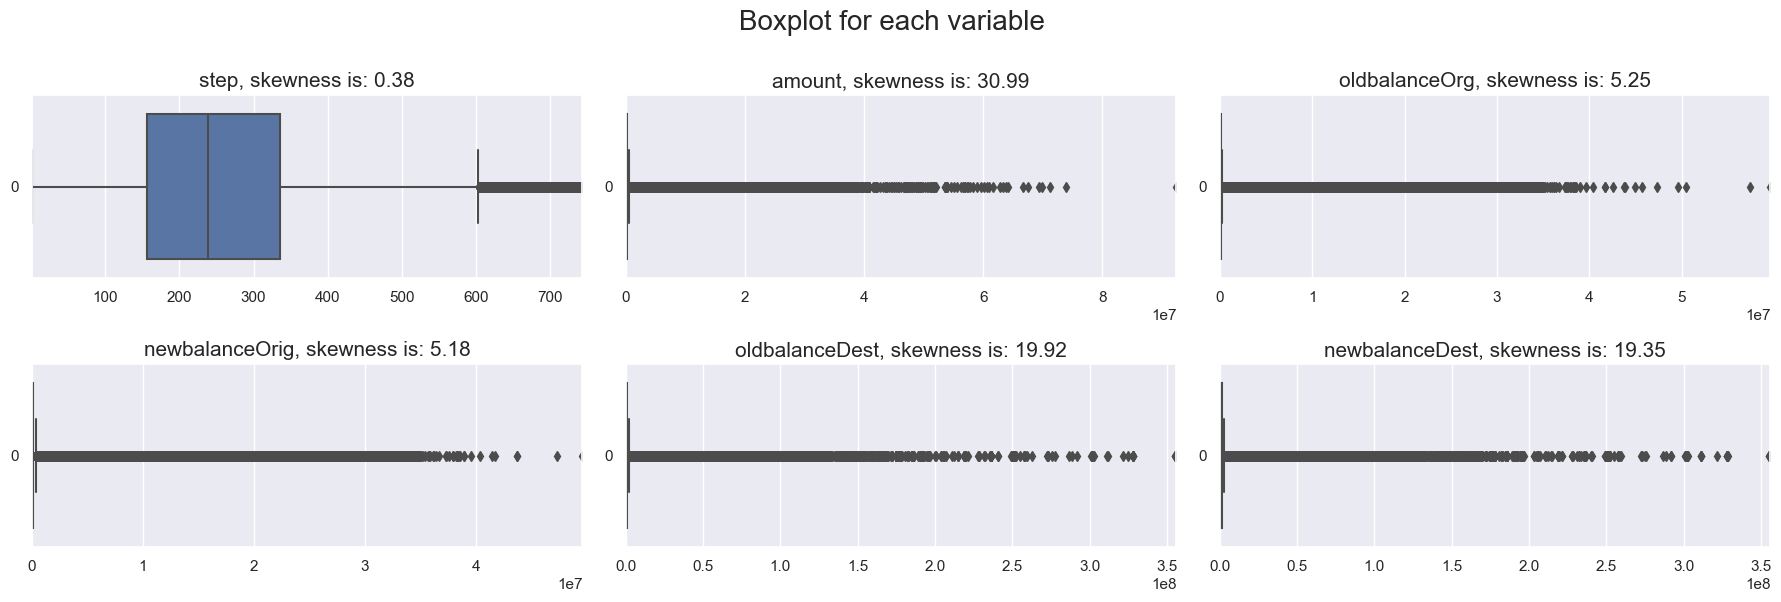

In [7]:
# Boxplot for each variable in numerical list

numerical=['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']

def boxplots_visual(data,column):
    fig, ax = plt.subplots(2,3,figsize=(18,6))
    fig.suptitle('Boxplot for each variable',y=1, size=20)
    ax=ax.flatten()
    for i,feature in enumerate(column):
        sns.boxplot(data=data[feature],ax=ax[i], orient='h')
        ax[i].set_title(feature+ ', skewness is: '+str(round(data[feature].skew(axis = 0, skipna = True),2)),fontsize=15)
        ax[i].set_xlim([min(data[feature]), max(data[feature])])
boxplots_visual(data=df,column=numerical)
plt.tight_layout()

In [8]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [9]:
# Checking isFlaggedFraud column
df['isFlaggedFraud'].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [10]:
# Dropping columns that are not needed
df.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1,inplace=True)
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [11]:
# Applying onehot encoding on type column
df = pd.get_dummies(df, columns=['type'], drop_first=True)
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,1,0


In [12]:
# We are using RobustScaler to scale down the numerical features as RobustScaler is less prone to outliers
scale=RobustScaler()
for feature in numerical:
    df[feature]=scale.fit_transform(df[feature].values.reshape(-1, 1))
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,-1.329609,-0.332932,1.452991,1.111175,-0.140722,-0.193057,0,0,0,1,0
1,-1.329609,-0.373762,0.065610,0.134375,-0.140722,-0.193057,0,0,0,1,0
2,-1.329609,-0.382380,-0.130708,0.000000,-0.140722,-0.193057,1,0,0,0,1
3,-1.329609,-0.382380,-0.130708,0.000000,-0.118260,-0.193057,1,1,0,0,0
4,-1.329609,-0.323571,0.254820,0.207169,-0.140722,-0.193057,0,0,0,1,0


In [13]:
# Splitting our data into independent and dependent features
X=df.drop('isFraud',axis=1)
y=df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
model = RandomForestClassifier()
model.fit(X, y)
print(model.feature_importances_)

[9.37271368e-02 1.58228811e-01 2.84567667e-01 2.27254948e-02
 7.01629037e-02 3.04624960e-01 2.30927060e-02 6.17328616e-05
 4.92357985e-04 4.23162298e-02]


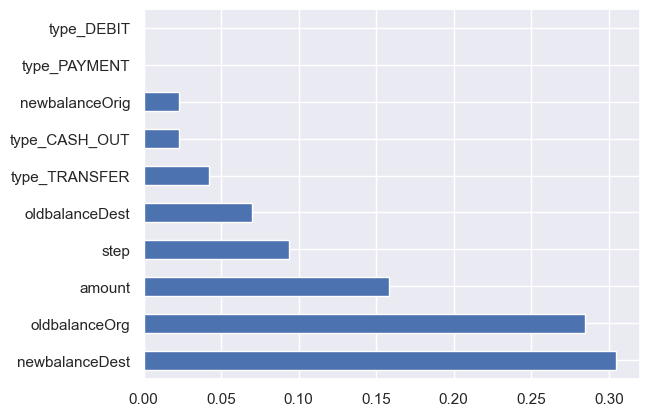

In [15]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [16]:
# Train the Logistic regression model using StratifiedKFold cross validation
skf=StratifiedKFold(n_splits=3, shuffle=False, random_state=None)
model1=LogisticRegression()

param={'C':10.0 **np.arange(-1,2)}
lrs=RandomizedSearchCV(model1,param,cv=skf,n_jobs=-1,scoring='accuracy', return_train_score=True)
lrs.fit(X_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': array([ 0.1,  1. , 10. ])},
                   return_train_score=True, scoring='accuracy')

In [17]:
# Get the performance of the logistic regression model
y_pred=lrs.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1270818      86]
 [    830     790]]
0.9992801707472708
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.90      0.49      0.63      1620

    accuracy                           1.00   1272524
   macro avg       0.95      0.74      0.82   1272524
weighted avg       1.00      1.00      1.00   1272524



In [18]:
# Train the Random Forest model using StratifiedKFold cross validation
model2 = RandomForestClassifier()
param = {'n_estimators': [40]}
rfc = GridSearchCV(model2, param, cv=skf, n_jobs=-1, scoring='accuracy', return_train_score=True)
rfc.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'n_estimators': [40]}, return_train_score=True,
             scoring='accuracy')

In [19]:
# Get the performance of the random forest model
y_pred2=rfc.predict(X_test)
print(confusion_matrix(y_test,y_pred2))
print(accuracy_score(y_test,y_pred2))
print(classification_report(y_test,y_pred2))

[[1270878      26]
 [    328    1292]]
0.9997218127123733
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.98      0.80      0.88      1620

    accuracy                           1.00   1272524
   macro avg       0.99      0.90      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524

